# Import required libraries

In [25]:
import numpy as np
import pandas as pd# Import cleaned dataset

import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics
import matplotlib.pyplot as plt # we only need pyplot

# For model training
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import cleaned dataset

In [26]:
# Load data back for EDA
news_data = pd.read_csv("cleaned_news_data.csv")
news_data.set_index("id", inplace=True)

In [27]:
news_data.shape

(20584, 29)

In [28]:
# View data
news_data.head()

,title,author,text,label,label_translated,title_charcount,text_charcount,title_wordcount,text_wordcount,stopwords_count_text,...,title_pos_noun,title_pos_num,title_pos_pron,title_pos_verb,text_pos_adj,text_pos_adv,text_pos_noun,text_pos_num,text_pos_pron,text_pos_verb
id,,,,,,,,,,,,,,,,,,,,,
0,hous dem aid even see comey letter jason chaff...,Darrell Lucus,hous dem aid even see comey letter jason chaff...,1,fake,81,4930,14,820,406,...,6,0,0,1,102,16,234,3,0,68
1,flynn hillari clinton big woman campu breitbart,Daniel J. Flynn,ever get feel life circl roundabout rather hea...,0,not fake,55,4160,9,710,330,...,5,0,0,1,81,13,208,3,3,45
2,truth might get fire,Consortiumnews.com,truth might get fire octob tension intellig an...,1,fake,33,7692,7,1266,575,...,2,0,0,2,155,33,385,4,3,92
3,civilian kill singl us airstrik identifi,Jessica Purkiss,video civilian kill singl us airstrik identifi...,1,fake,63,3237,10,557,244,...,2,0,1,1,74,5,158,6,12,44
4,iranian woman jail fiction unpublish stori wom...,Howard Portnoy,print iranian woman sentenc six year prison ir...,1,fake,93,938,14,154,64,...,7,0,0,1,13,5,54,2,0,11


# Model training

## Attempt 1: Decision Tree

### Finding out what variables are the most impactful

In [29]:
def auto_kfold_decision_tree(variables):
    # Init list to record scores
    scores = {}
    
    # Response
    news_res = news_data['label_translated']
    
    # Train for every variable
    for variable in variables:
        if variable.dtype == np.dtype('int64'):
            # Numeric variable
            news_cat = pd.DataFrame(variable)
            newsdata_ohe = pd.concat([news_cat, news_res], sort = False, axis = 1).reindex(index=news_cat.index)
        elif variable.dtype == np.dtype('object'):
            # Categorical variables
            # Import the encoder from sklearn
            ohe = OneHotEncoder()
            # OneHotEncoding of categorical predictors (not the response)
            news_cat = pd.DataFrame(variable)

            ohe.fit(news_cat)
            news_cat_ohe = pd.DataFrame(ohe.transform(news_cat).toarray(), columns=ohe.get_feature_names(news_cat.columns))
            
            newsdata_ohe = pd.concat([news_cat_ohe, news_res], sort = False, axis = 1).reindex(index=news_cat_ohe.index)

        # Extract Response and Predictors
        y = pd.DataFrame(newsdata_ohe['label_translated'])
        X = pd.DataFrame(newsdata_ohe.drop('label_translated', axis = 1))

        # Split the Dataset into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

        # Decision Tree using Train Data
        dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
        cv_results = cross_val_score(dectree, X_train, y_train['label_translated'], cv=skf)

        # Record score
        scores[variable.name] = cv_results
        
    return scores

In [30]:
variables = [news_data['title_charcount'], 
             news_data['text_charcount'], 
             news_data['title_wordcount'], 
             news_data['text_wordcount'], 
             news_data['stopwords_count_text'], 
             news_data['stopwords_count_title'], 
             news_data['title_polarity'], 
             news_data['text_polarity'], 
             news_data['title_emotion'], 
             news_data['text_emotion'], 
             news_data['title_pos_adj'], 
             news_data['title_pos_adv'], 
             news_data['title_pos_noun'], 
             news_data['title_pos_num'], 
             news_data['title_pos_pron'], 
             news_data['title_pos_verb'], 
             news_data['text_pos_adj'], 
             news_data['text_pos_adv'], 
             news_data['text_pos_noun'], 
             news_data['text_pos_num'], 
             news_data['text_pos_pron'], 
             news_data['text_pos_verb']
            ]

scores = auto_kfold_decision_tree(variables)


for key, value in sorted(scores.items(), key=lambda x: x[1].mean(), reverse=True):
    print(f"Predictor: {key}, score: {value.mean():.2f}")

Predictor: title_wordcount, score: 0.70
Predictor: title_charcount, score: 0.68
Predictor: title_pos_adj, score: 0.67
Predictor: stopwords_count_text, score: 0.64
Predictor: text_pos_noun, score: 0.63
Predictor: text_charcount, score: 0.63
Predictor: title_pos_noun, score: 0.63
Predictor: text_wordcount, score: 0.63
Predictor: text_pos_adj, score: 0.63
Predictor: text_pos_verb, score: 0.63
Predictor: text_pos_num, score: 0.62
Predictor: text_pos_adv, score: 0.62
Predictor: stopwords_count_title, score: 0.58
Predictor: title_pos_verb, score: 0.57
Predictor: text_pos_pron, score: 0.55
Predictor: title_polarity, score: 0.54
Predictor: text_emotion, score: 0.54
Predictor: title_emotion, score: 0.54
Predictor: title_pos_pron, score: 0.52
Predictor: title_pos_adv, score: 0.51
Predictor: text_polarity, score: 0.51
Predictor: title_pos_num, score: 0.50


### Training with top predictors

In [31]:
news_num = news_data[['title_wordcount','title_pos_adj','stopwords_count_text','title_pos_noun','text_wordcount']]
news_res = news_data['label_translated']
news_final = pd.concat([news_num,news_res],sort=False,axis=1).reindex(index=news_num.index)
# Check the final dataframe
news_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20584 entries, 0 to 20583
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   title_wordcount       20584 non-null  int64 
 1   title_pos_adj         20584 non-null  int64 
 2   stopwords_count_text  20584 non-null  int64 
 3   title_pos_noun        20584 non-null  int64 
 4   text_wordcount        20584 non-null  int64 
 5   label_translated      20584 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


### Create and fit model using decision tree


In [32]:
# Extract Response and Predictors
y = pd.DataFrame(news_final['label_translated'])
X = pd.DataFrame(news_final.drop('label_translated', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # change max_depth to experiment



### Stratified k- fold for decision tree

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_results = cross_val_score(dectree, X_train, y_train['label_translated'], cv=skf)

In [34]:
cv_results, cv_results.mean()


(array([0.72935461, 0.73560028, 0.7369882 , 0.72405415, 0.73030198]),
 0.731259844283577)

### Fitting data into decision tree


In [35]:
dectree.fit(X_train, y_train)                    # train the decision tree model

DecisionTreeClassifier(max_depth=4)

### Decision tree evaluation

#### Plotting decision tree

[Text(669.6, 1141.5600000000002, 'title_wordcount <= 11.5\ngini = 0.5\nsamples = 14408\nvalue = [7111, 7297]\nclass = Not Fake'),
 Text(334.8, 815.4000000000001, 'title_wordcount <= 7.5\ngini = 0.4\nsamples = 5889\nvalue = [4262, 1627]\nclass = Fake'),
 Text(167.4, 489.24, 'title_pos_noun <= 4.5\ngini = 0.18\nsamples = 1572\nvalue = [1415, 157]\nclass = Fake'),
 Text(83.7, 163.07999999999993, '\n  (...)  \n'),
 Text(251.10000000000002, 163.07999999999993, '\n  (...)  \n'),
 Text(502.20000000000005, 489.24, 'stopwords_count_text <= 46.5\ngini = 0.449\nsamples = 4317\nvalue = [2847, 1470]\nclass = Fake'),
 Text(418.5, 163.07999999999993, '\n  (...)  \n'),
 Text(585.9, 163.07999999999993, '\n  (...)  \n'),
 Text(1004.4000000000001, 815.4000000000001, 'stopwords_count_text <= 230.5\ngini = 0.445\nsamples = 8519\nvalue = [2849, 5670]\nclass = Not Fake'),
 Text(837.0, 489.24, 'stopwords_count_text <= 47.5\ngini = 0.498\nsamples = 3202\nvalue = [1708, 1494]\nclass = Fake'),
 Text(753.30000000

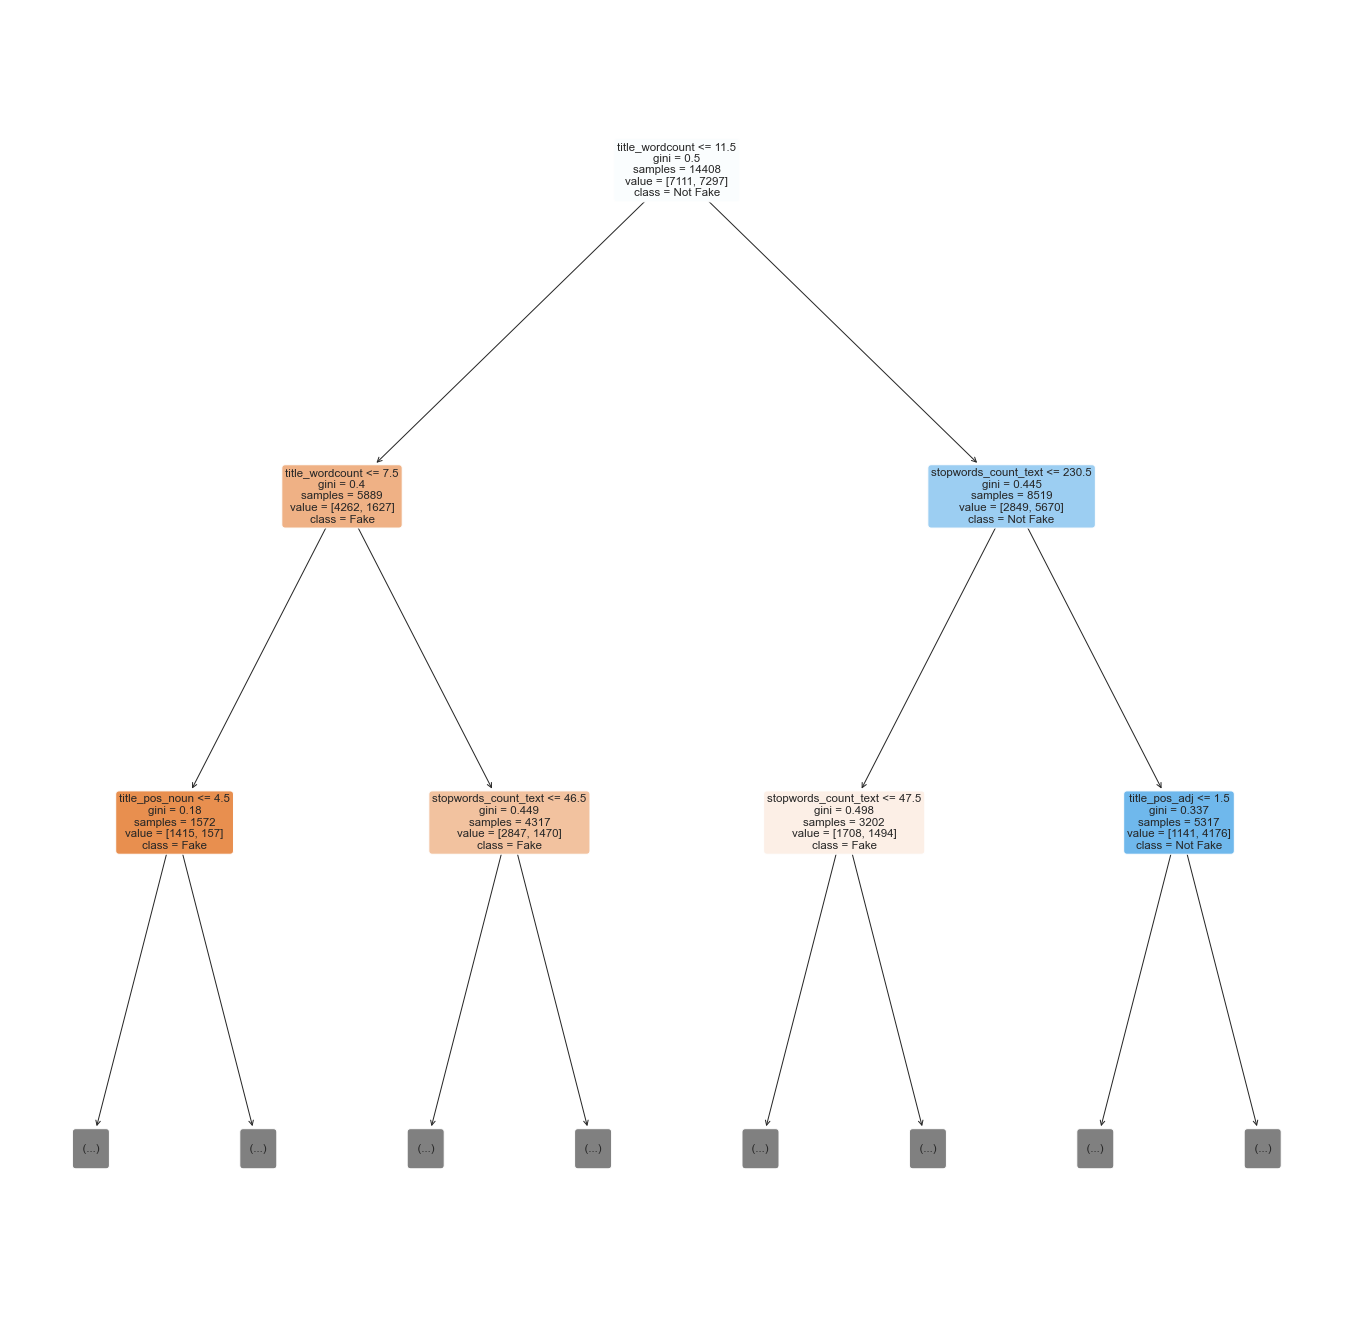

In [36]:
# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, max_depth=2,
          feature_names=X_train.columns, 
          class_names=["Fake","Not Fake"])

#### Confusion matrix

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Train Data
Accuracy  :	 0.7318156579677957

TPR Train :	 0.6971358092366726
TNR Train :	 0.7674026156658698

FPR Train :	 0.2325973843341302
FNR Train :	 0.3028641907633274


<AxesSubplot:>

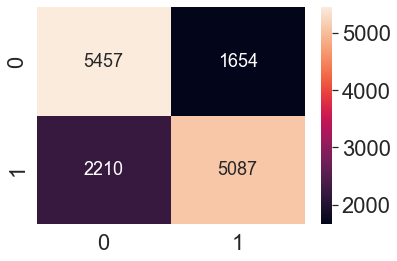

In [37]:
# Predict the Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", dectree.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7313795336787565

TPR Test :	 0.6869537067011978
TNR Test :	 0.7758341431810819

FPR Test :	 0.22416585681891804
FNR Test :	 0.3130462932988022


<AxesSubplot:>

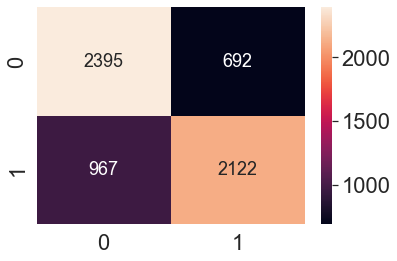

In [38]:
# Predict the Response corresponding to Predictors
y_test_pred = dectree.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", dectree.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

## Attempt 2: Random forest classifier



In [39]:
# Extract Response and Predictors
y = pd.DataFrame(news_final['label_translated'])
X = pd.DataFrame(news_final.drop('label_translated', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [40]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 100,  # n_estimators denote number of trees
                                 max_depth = 4)       # set the maximum depth of each tree



### Stratified k-fold verification for random forest classifier

In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_results = cross_val_score(rforest, X_train, y_train['label_translated'], cv=skf)

In [42]:
cv_results, cv_results.mean()


(array([0.73004858, 0.73004858, 0.74739764, 0.74800417, 0.72370705]),
 0.7358412013331981)

### Fitting data into forest 

In [43]:
# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.label_translated.ravel())

RandomForestClassifier(max_depth=4)

### Random Forest model evaluation

### Confusion Matrix

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Train Data
Accuracy  :	 0.7384092171016102

TPR Train :	 0.7238424326192122
TNR Train :	 0.753101909940053

FPR Train :	 0.24689809005994703
FNR Train :	 0.27615756738078784


<AxesSubplot:>

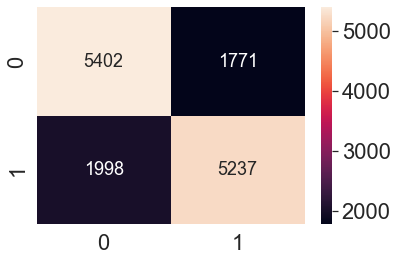

In [44]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

Test Data
Accuracy  :	 0.7291126943005182

TPR Test :	 0.7280228498889242
TNR Test :	 0.7302479338842975

FPR Test :	 0.26975206611570246
FNR Test :	 0.27197715011107587


<AxesSubplot:>

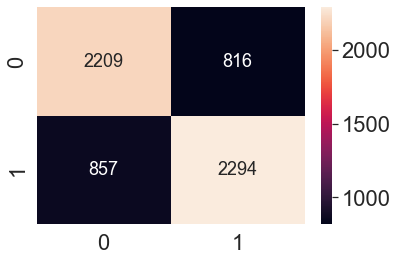

In [45]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

### Trying to improve accuracy by hyperparameter tuning using Cross-Validation(CV)

In [46]:
# Extract Response and Predictors
y = pd.DataFrame(news_final['label_translated'])
X = pd.DataFrame(news_final.drop('label_translated', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [47]:
# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),   # number of trees 100, 200, ..., 1000
              'max_depth': np.arange(2, 11)}             # depth of trees 2, 3, 4, 5, ..., 10

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'accuracy')       # score to evaluate

# Train the models using Cross-Validation
hpGrid.fit(X_train, y_train.label_translated.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

In [48]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=10, n_estimators=500)
0.7503467765187747


#### Best result is max depth = 10 n_estimators = 1000 accuracy = 0.76
#### This prompts us to use another machine learning algorithm to try to improve our accuracy